# Auditing a CNN trained on CIFAR10 using the Population Attack

## Introduction

In this tutorial, we will see:

- How to specify the dataset and model for Privacy Meter
- How to audit a Tensorflow model
- How to use the `PopulationMetric` to evaluate membership leakage using loss values from the target model

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/privacytrustlab/ml_privacy_meter/blob/master/advanced/population_metric.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privacytrustlab/ml_privacy_meter/blob/master/advanced/population_metric.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View GitHub</a>
  </td>
</table>

## Imports

In [1]:
import numpy as np
import tensorflow as tf

2022-12-21 20:26:26.695984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:
2022-12-21 20:26:26.696006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


For now we install the Privacy Meter library from the local source. A version will be pushed to pip soon.

In [2]:
import sys
!{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import TensorflowModel

Obtaining file:///home/hongyan/Desktop/upgrade_privacy_meter/ml_privacy_meter
  Attempting uninstall: privacy-meter
    Found existing installation: privacy-meter 1.0
    Uninstalling privacy-meter-1.0:
      Successfully uninstalled privacy-meter-1.0
  Running setup.py develop for privacy-meter


## Settings

Hyperparameters:

In [3]:
# for training the target model
num_train_points = 5000
num_test_points = 5000
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optim_fn = 'adam'
epochs = 25
batch_size = 64
regularizer_penalty = 0.01
regularizer = tf.keras.regularizers.l2(l=regularizer_penalty)

In [4]:
# for the population metric
num_population_points = 10000
fpr_tolerance_list = [
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
]

## Dataset creation

We use the CIFAR10 dataset for this tutorial. As Tensorflow already has the data loading code for CIFAR10, we just need to add our pre-processing code on top of it.

In [5]:
def preprocess_cifar10_dataset():
    input_shape, num_classes = (32, 32, 3), 10

    # split the data between train and test sets
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # convert labels into one hot vectors
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, input_shape, num_classes

x_train_all, y_train_all, x_test_all, y_test_all, input_shape, num_classes = preprocess_cifar10_dataset()

CIFAR10 comes with the predetermined train and test partitions. We further split the train partition into two more sets - 'train' and 'population' for the audit. 

We will have the following sets at the end of this partitioning:

- The 'train' set will be used to train the target model. It will be used as the 'member' set for the audit.
- The 'test' set will be used as the 'non-member' set for the audit.
- The 'population' set will be used as the reference data by the `PopulationMetric`.

In [6]:
x_train, y_train = x_train_all[:num_train_points], y_train_all[:num_train_points]
x_test, y_test = x_test_all[:num_test_points], y_test_all[:num_test_points]
x_population = x_train_all[num_train_points:(num_train_points + num_population_points)]
y_population = y_train_all[num_train_points:(num_train_points + num_population_points)]

We wrap the sets into a `Dataset` object, which takes in the following arguments:

- `data_dict` contains the actual dataset, in the form of a 2D dictionary. The first key corresponds to the split name (here we have two: "train" and "test"), and the second key to the feature name (here we also have two: "x" and "y").
- `default_input` contains the name of the feature that should be used as the models input (here "x").
- `default_output` contains the name of the feature that should be used as the label / models output (here "y").

In [7]:
# create the target model's dataset
train_ds = {'x': x_train, 'y': y_train}
test_ds = {'x': x_test, 'y': y_test}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y'
)

# create the reference dataset
population_ds = {'x': x_population, 'y': y_population}
reference_dataset = Dataset(
    # this is the default mapping that a Metric will look for
    # in a reference dataset
    data_dict={'train': population_ds},
    default_input='x', default_output='y'
)

## Training the target model

We define the Tensorflow model to be used as the target model:

In [8]:
def get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                                     input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                                     kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

And we compile and train the target model using the target dataset we defined above:

In [9]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')
model = get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer)
model.summary()
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

2022-12-21 20:26:34.095628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:
2022-12-21 20:26:34.095723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:
2022-12-21 20:26:34.095752: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-21 20:26:34.096366: I tensorflow/core/platform/c

79/79 - 1s - loss: 2.4154 - accuracy: 0.1970 - 1s/epoch - 13ms/step
Epoch 2/25
79/79 - 1s - loss: 2.0280 - accuracy: 0.3104 - 706ms/epoch - 9ms/step
Epoch 3/25
79/79 - 1s - loss: 1.8595 - accuracy: 0.3838 - 739ms/epoch - 9ms/step
Epoch 4/25
79/79 - 1s - loss: 1.7740 - accuracy: 0.4118 - 791ms/epoch - 10ms/step
Epoch 5/25
79/79 - 1s - loss: 1.7439 - accuracy: 0.4220 - 777ms/epoch - 10ms/step
Epoch 6/25
79/79 - 1s - loss: 1.6892 - accuracy: 0.4408 - 773ms/epoch - 10ms/step
Epoch 7/25
79/79 - 1s - loss: 1.6405 - accuracy: 0.4634 - 781ms/epoch - 10ms/step
Epoch 8/25
79/79 - 1s - loss: 1.6113 - accuracy: 0.4720 - 721ms/epoch - 9ms/step
Epoch 9/25
79/79 - 1s - loss: 1.5739 - accuracy: 0.4796 - 707ms/epoch - 9ms/step
Epoch 10/25
79/79 - 1s - loss: 1.5616 - accuracy: 0.4948 - 698ms/epoch - 9ms/step
Epoch 11/25
79/79 - 1s - loss: 1.5432 - accuracy: 0.4920 - 669ms/epoch - 8ms/step
Epoch 12/25
79/79 - 1s - loss: 1.5219 - accuracy: 0.5040 - 695ms/epoch - 9ms/step
Epoch 13/25
79/79 - 1s - loss: 1.5

We wrap the trained target model in a `TensorflowModel` object. Note that we need to pass a loss function to this object.

In [10]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)

## Information sources

We can now define two `InformationSource` objects. Basically, an information source is an abstraction representing a set of models, and their corresponding datasets. Note that for the `PopulationMetric` we use the same model in both the target and reference information sources, but the datasets that will be queried will differ.

In [11]:
target_info_source = InformationSource(
    models=[target_model], 
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

## Metric and Audit

We now create a `Metric` object, which is an abstraction representing an algorithm used to measure something on an `InformationSource`, such as membership information leakage. In this case, we use the `PopulationMetric` to measure the membership information leakage of `target_info_source` in a black-box setting, using loss values returned by the target model on the `reference_info_source`.

The `Audit` object is a wrapper to actually run the audit, and display the results. More visualization options will be added soon.

As we will be using the default version of the `PopulationMetric`, we pass the `POPULATION` enum value as the metric argument for the `Audit` object.

In [12]:
audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)

In [13]:
audit_obj.prepare()
audit_results = audit_obj.run()[0]

Results are stored in: ['/home/hongyan/Desktop/upgrade_privacy_meter/ml_privacy_meter/docs/log_2022-12-21_20-26-52-000']


In [14]:
for result in audit_results:
    print(result)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.54651938
FPR               = 0.0
TN, FP, FN, TP    = (5000, 0, 5000, 0)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5068
ROC AUC Score     = 0.54651938
FPR               = 0.1048
TN, FP, FN, TP    = (4476, 524, 4408, 592)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.517
ROC AUC Score     = 0.54651938
FPR               = 0.208
TN, FP, FN, TP    = (3960, 1040, 3790, 1210)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5244
ROC AUC Score     = 0.54651938
FPR               = 0.3076
TN, FP, FN, TP    = (3462, 1538, 3218, 1782)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.53
ROC AUC Score     = 0.54651938
FPR               = 0.4108
TN, FP, FN, TP    = (2946, 2054, 2646, 2354)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5342
ROC AUC Score     = 0.54651938
FPR        

## Result visualization

Several visualization tools are built in `privacy_tool`, such as ROC curves, signal values histogram, or confusion matrix.

In [15]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

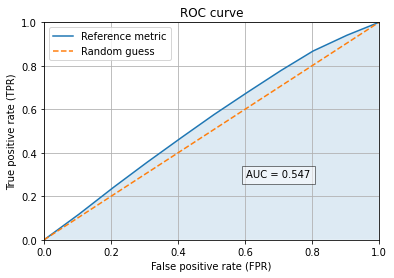

<Figure size 432x288 with 0 Axes>

In [16]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

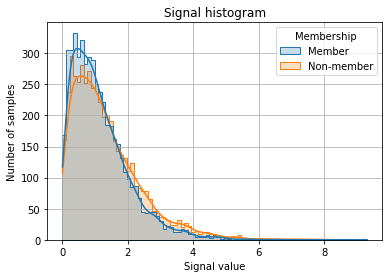

<Figure size 432x288 with 0 Axes>

In [19]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)